# 🎲 Board Games Analysis Project 🎲
----

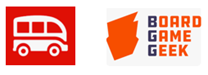

The **Board Game Analysis** project aims to explore and analyze data from **[BoardGameGeek](https://boardgamegeek.com/)** (also known as **BGG**), one of the largest online communities for board game enthusiasts. 

This project will delve into the characteristics of board games and their relationships with user ratings, providing insights into what makes a game highly rated and popular.

#### 🚀 Authors : Maxence Dauphin, Bernhard Riemer, Mónica Costa, Tahar Guenfoud, Konstantin Shapovalov
#### 🎯 Batch #1835 Data Science Flex



# Importing Libraries
------

In [106]:
import os
import subprocess
import re

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display="diagram")
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import CountVectorizer

# Load data from Kaggle
---

⬇️ **Getting the data**

The project is based on a **BoardGameGeek** dataset coming from [Kaggle](https://www.kaggle.com/api/v1/datasets/download/melissamonfared/board-games). 

Once downloaded, the *archive.zip* obtained is stored inside the **raw_data** folder. Then, the archive is unzipped in order to extract the dataset as a *.csv file*. If the archive path already exists, we can ignore the download and re-use our previous data.

In [107]:
# Define the path to raw_data repo
raw_data_path = "~/code/maxencedauphin/bgg-project/raw_data"
raw_data_path = os.path.expanduser(raw_data_path)

# Define the url to Kaggle data
kaggle_data_path = "https://www.kaggle.com/api/v1/datasets/download/melissamonfared/board-games"

# Define the archive path
archive_path = os.path.join(raw_data_path, "archive.zip")

# Check if the archive exists
if os.path.exists(archive_path):
    try:
        print("Archive exists. Please enter 'yes' to reload data or 'no' to keep existing data.")
        user_input = input("Enter your choice (yes/no): ")

        if user_input.lower() == "yes":
            subprocess.run(f"curl -L -o {archive_path} {kaggle_data_path}", shell=True)
            subprocess.run(f"unzip -o {archive_path} -d {raw_data_path}", shell=True)
        else:
            print("Keeping existing data.")
    except EOFError:
        print("User input not supported in this environment. Proceeding with default action.")
        print("Keeping existing data.")
else:
    subprocess.run(f"curl -L -o {archive_path} {kaggle_data_path}", shell=True)
    subprocess.run(f"unzip {archive_path} -d {raw_data_path}", shell=True)

Archive exists. Please enter 'yes' to reload data or 'no' to keep existing data.
Keeping existing data.


The dataset (named df) can be open through the *read_csv* method of **pandas** :

In [108]:
filepath = "~/code/maxencedauphin/bgg-project/raw_data/BGG_Data_Set.csv"
df_orig = pd.read_csv(filepath, encoding='ISO-8859-1')
df = df_orig.copy()

Once the dataset loaded, we can start exploring the data we have ! 🔎

# Exploratory Data Analysis (EDA)
---

⬇️ **Exploratory Data analysis** 

Let's get familiar with the dataset first :
- How does it look like ?
- What are the rows ? 
- What are the columns ?
- What is the shape of the dataset ?


In [109]:
df.head(2)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"


In [110]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Total rows : 20343, Total columns : 14


Is there any duplicates inside the dataset ?

In [111]:
# DUPLICATES
df.duplicated().sum()

np.int64(0)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  float64
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  float64
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(5), int64(6), object(3)
memory usage: 2.2+ MB


In [113]:
df.dtypes.value_counts()

int64      6
float64    5
object     3
Name: count, dtype: int64

In [114]:
df.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

Name         19974
Mechanics     7381
Domains         39
dtype: int64

In [115]:
df.select_dtypes(include=["float64"]).nunique().sort_values(ascending=False)

ID                    20327
Owned Users            3997
Rating Average          622
Complexity Average      379
Year Published          188
dtype: int64

In [116]:
df.select_dtypes(include=["int64"]).nunique().sort_values(ascending=False)

BGG Rank       20343
Users Rated     2973
Play Time        116
Max Players       54
Min Age           21
Min Players       11
dtype: int64

In [117]:
df.describe()

,ID,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
count,20327.000000,20342.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20320.000000
mean,108216.245142,1984.249877,2.019712,5.672221,91.294548,9.601485,840.971391,6.403227,10172.890429,1.991188,1408.457628
std,98682.097298,214.003181,0.690366,15.231376,545.447203,3.645458,3511.562220,0.935911,5872.831597,0.848903,5040.179315
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.050000,1.000000,0.000000,0.000000
25%,11029.000000,2001.000000,2.000000,4.000000,30.000000,8.000000,55.000000,5.820000,5087.500000,1.330000,146.000000
50%,88931.000000,2011.000000,2.000000,4.000000,45.000000,10.000000,120.000000,6.430000,10173.000000,1.970000,309.000000
75%,192939.500000,2016.000000,2.000000,6.000000,90.000000,12.000000,385.000000,7.030000,15258.500000,2.540000,864.000000
max,331787.000000,2022.000000,10.000000,999.000000,60000.000000,25.000000,102214.000000,9.580000,20344.000000,5.000000,155312.000000


#### 🤔 My reflections:

- convert column names to lowercase and replace spaces with underscores to facilitate using pandas df.name syntax
- remove the game ID column as it does not provide inherent information about the game's quality or rating
- remove rows where the value for owned_users is NaN
- replace missing values in the mechanics and domains columns with "unspecified"
- rework mechanics and domains columns which contains a list of strings
- we have numerous categorical values to encode: 19,974 for name, 7,379 for mechanics, and 40 for domains. To maintain a simple basic model, I removed the name column

TODO
- we need to rework the year_published column to handle NaN, 0, and negative values, which represent very old games dated "BC"
- we need to transform the list values in mechanics and domains into something more meaningful
- ...


#### 🛍️ Convert column names to lowercase and replace spaces with underscores to facilitate using pandas df.name syntax

In [118]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Output the transformed column names
print(df.columns)

Index(['id', 'name', 'year_published', 'min_players', 'max_players',
       'play_time', 'min_age', 'users_rated', 'rating_average', 'bgg_rank',
       'complexity_average', 'owned_users', 'mechanics', 'domains'],
      dtype='object')


#### 🛍️ Remove the game ID column as it does not provide inherent information about the game's quality or rating

In [119]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Total rows : 20343, Total columns : 14


In [120]:
df.drop(columns=['id'], inplace=True)

In [121]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Total rows : 20343, Total columns : 13


#### 🛍️ Remove rows where the value for owned_users is NaN

In [122]:
df = df[df['owned_users'].notna()]

In [123]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

Total rows : 20320, Total columns : 13


#### 🛍️ Replace missing values in the mechanics and domains columns with "unspecified"

In [124]:
print("Columns with missing values:", df.columns[df.isnull().any()])

Columns with missing values: Index(['mechanics', 'domains'], dtype='object')


Changing any NA value inside the mechanics / domains column into an "unspecified" mechanic / domain value. This ensure to not deal with NA values.

In [125]:
df["mechanics"] = df["mechanics"].fillna("unspecified mechanic")
df["domains"] = df["domains"].fillna("unspecified domain")


**Note :** Since these columns values will be used as columns later, we should not use the same word to design an undertermined value. Thus, we specify either mechanic or domain behind "unspecified".

In [126]:
print("Columns with missing values:", df.columns[df.isnull().any()])

Columns with missing values: Index([], dtype='object')


#### 🛍️ Rework mechanics and domains columns which contains a list of strings

In [127]:
df.mechanics

0        Action Queue, Action Retrieval, Campaign / Bat...
1        Action Points, Cooperative Game, Hand Manageme...
2        Hand Management, Income, Loans, Market, Networ...
3        Card Drafting, Drafting, End Game Bonuses, Han...
4        Action Drafting, Area Majority / Influence, Ar...
                               ...                        
20338                                 unspecified mechanic
20339     Betting and Bluffing, Bingo, Pattern Recognition
20340                                 Roll / Spin and Move
20341    Dice Rolling, Grid Movement, Race, Roll / Spin...
20342                   Paper-and-Pencil, Pattern Building
Name: mechanics, Length: 20320, dtype: object

In [128]:
def clean(text):
    """
    This function aims to clean a list of words. "
    It takes a string of words separated by a comma as an input,
    and returns the same string, but without space or slashes inbetween words.
    Ex :
    - Before a clean function: Action Drafting, Area Majority / Influence, ...
    - After a clean function: Action Drafting,Area Majority,Influence,...
    """
    # This part replace empty words between commas, and separate slashed words by a comma
    cln = re.sub(', ,', ' ', str(text))
    cln = cln.replace(" /",",")
    cln = cln.replace("/",",")
    #cln = cln.lower() # if it is case sensitive, might be good to lowercase.

    # This part enable to separate and join again the slashed words, and to get rid of spaces after the comma
    """
    Ex : 'Action', 'Drafting,...', -> 'Action Drafting,...'
    """
    cln = cln.split()
    cln = ' '.join(cln)
    cln = cln.split(', ')
    cln = ','.join(cln)
    return cln


Below an example of the clean function doing : 

In [129]:
print("Before a clean function:\n", df_orig.Mechanics.iloc[4])
print("After a clean function:\n", clean(df_orig.Mechanics.iloc[4]))

Before a clean function:
 Action Drafting, Area Majority / Influence, Area-Impulse, Dice Rolling, Follow, Grid Movement, Hexagon Grid, Modular Board, Trading, Variable Phase Order, Variable Player Powers, Voting
After a clean function:
 Action Drafting,Area Majority,Influence,Area-Impulse,Dice Rolling,Follow,Grid Movement,Hexagon Grid,Modular Board,Trading,Variable Phase Order,Variable Player Powers,Voting


We can apply the clean functions to both **mechanics** and **domains** columns : 

In [130]:
df["mechanics"] = df["mechanics"].apply(clean)
df["domains"] = df["domains"].apply(clean)

Finally, we have a clean string of words separated by just a comma in each row :

In [131]:
print("Mechanics column :\n", df.mechanics.head(5))
print("\nDomains column :\n",df.domains.head(5))

Mechanics column :
 0    Action Queue,Action Retrieval,Campaign,Battle ...
1    Action Points,Cooperative Game,Hand Management...
2    Hand Management,Income,Loans,Market,Network an...
3    Card Drafting,Drafting,End Game Bonuses,Hand M...
4    Action Drafting,Area Majority,Influence,Area-I...
Name: mechanics, dtype: object

Domains column :
 0    Strategy Games,Thematic Games
1    Strategy Games,Thematic Games
2                   Strategy Games
3                   Strategy Games
4    Strategy Games,Thematic Games
Name: domains, dtype: object


In order to get to know how many mechanics there are in the entire DataFrame, without an appropriate tool, we can already guess that we would have to go through the entire string each time, save each word or combination of words used, and check the next one to see if it's a new one or if it's already in the list... isn't there a tool to exactly do this ?

➡️ There is one 😉, and it's called **Vectorizing** ! (*see module 5.11. Natural Language Processing*)

We can effectively consider each row of mechanics and domains as a **bag of word** that we have to count, using *CountVectorizer()*. We just have to specify that each word is between commas thanks to the *token_pattern* argument (in order to just count the words or combination of words between commas, and not count *each* word inbetween the words, like 'as', 'and', etc.).

In [132]:
# token_pattern founds :
# token_pattern = r"\w+\s*-*\w*\s*-*\w*\s*-*\w*\s*-*\w*\b"
# token_pattern = \w+(\s*-*\w*){0,3}\b # not working
token_pattern = r"([^,]+)"
mechanics_count_vectorizer = CountVectorizer(token_pattern = token_pattern)
domains_count_vectorizer = CountVectorizer(token_pattern = token_pattern)

mechanics_columns = mechanics_count_vectorizer.fit_transform(df['mechanics'])
domains_columns = domains_count_vectorizer.fit_transform(df['domains'])

vectorized_mechanics = pd.DataFrame(mechanics_columns.toarray(),
                                    columns = mechanics_count_vectorizer.get_feature_names_out()
                                    )
print(vectorized_mechanics.columns)

vectorized_domains = pd.DataFrame(domains_columns.toarray(),
                                    columns = domains_count_vectorizer.get_feature_names_out()
                                    )
print(vectorized_domains.columns)

Index(['acting', 'action', 'action drafting', 'action points', 'action queue',
       'action retrieval', 'action timer', 'advantage token', 'alliances',
       'area majority',
       ...
       'turn order: stat-based', 'unspecified mechanic',
       'variable phase order', 'variable player powers', 'variable set-up',
       'victory points as a resource', 'voting', 'worker placement',
       'worker placement with dice workers', 'zone of control'],
      dtype='object', length=195)
Index(['abstract games', 'children's games', 'customizable games',
       'family games', 'party games', 'strategy games', 'thematic games',
       'unspecified domain', 'wargames'],
      dtype='object')


❓ Can we now concatenate the DataFrame with our new vectorized mechanics and domains ? 

‼️ **But before that** you might have noticed that the indexes of DataFrame goes to 20342, but has 20320 items.
And that when you call for df.mechanics, it specifies that there are 20320 rows. 
But the final index row is *20319*, whereas the one from df is *20342*. 
Therefore, we have a mismatch of indexes. That will lead to some NA if we don't take care of this, because the concatenation (as the merge) will be done on the indexes !
That's why we're using the *.reset_index(drop=True)* method on our DataFrame : to reset the index and forces the match between both DataFrames.

➡️ After that, we can effectively concatenate the DataFrame with our new vectorized mechanics and domains, and drop the mechanics and domains columns !


In [133]:
## test = pd.merge([df, vectorized_mechanics], axis = 1, join = 'inner', ignore_index=False)
df = df.copy().reset_index(drop=True)
df = pd.concat([df, vectorized_mechanics, vectorized_domains], axis = 1)
## test = test.merge(vectorized_mechanics, how='left', left_index=True, right_index = True)
# print(test)
df.drop(['mechanics', 'domains'], axis = 1, inplace = True)
df.head(5)

,name,year_published,min_players,max_players,play_time,min_age,users_rated,rating_average,bgg_rank,complexity_average,owned_users,acting,action,action drafting,action points,action queue,action retrieval,action timer,advantage token,alliances,area majority,area movement,area-impulse,auction,auction: dexterity,auction: dutch,auction: dutch priority,auction: english,auction: fixed placement,auction: once around,auction: sealed bid,auction: turn order until pass,automatic resource growth,battle card driven,betting and bluffing,bias,bidding,bingo,bribery,campaign,campaign game,card drafting,card play conflict resolution,catch the leader,chaining,chit-pull system,closed economy auction,combat results table,command cards,commodity speculation,communication limits,connections,constrained bidding,contracts,cooperative game,crayon rail system,critical hits and failures,cube tower,deck bag and pool building,deck construction,deduction,delayed purchase,dice rolling,die icon resolution,different dice movement,different worker types,drafting,elapsed real time ending,enclosure,end game bonuses,event,events,finale ending,flicking,follow,force commitment,grid coverage,grid movement,hand management,hexagon grid,hidden movement,hidden roles,hidden victory points,highest-lowest scoring,hot potato,i cut you choose,impulse movement,income,increase value of unchosen resources,induction,influence,interrupts,investment,kill steal,king of the hill,ladder climbing,layering,legacy game,line drawing,line of sight,loans,lose a turn,mancala,map addition,map deformation,map reduction,market,matching,measurement movement,melding and splaying,memory,minimap resolution,mission,modular board,move through deck,movement points,movement template,moving multiple units,multiple maps,multiple-lot auction,narrative choice,negotiation,network and route building,once-per-game abilities,order counters,ownership,paper-and-pencil,paragraph,passed action token,pattern building,pattern movement,pattern recognition,physical removal,pick-up and deliver,pieces as map,player elimination,player judge,point to point movement,predictive bid,prisoner's dilemma,programmed movement,push,push your luck,race,random production,ratio,re-rolling and locking,real-time,relative movement,resource to move,rock-paper-scissors,role playing,roles with asymmetric information,roll,rondel,scenario,score-and-reset game,secret unit deployment,selection order bid,semi-cooperative game,set collection,simulation,simultaneous action selection,singing,single loser game,slide,solitaire game,solo,speed matching,spin and move,square grid,stacking and balancing,stat check resolution,static capture,stock holding,storytelling,sudden death ending,take that,targeted clues,team-based game,tech tracks,tech trees,three dimensional movement,tile placement,time track,track movement,trading,traitor game,trick-taking,tug of war,turn order: auction,turn order: claim action,turn order: pass order,turn order: progressive,turn order: random,turn order: role order,turn order: stat-based,unspecified mechanic,variable phase order,variable player powers,variable set-up,victory points as a resource,voting,worker placement,worker placement with dice workers,zone of control,abstract games,children's games,customizable games,family games,party games,strategy games,thematic games,unspecified domain,wargames
0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

In [134]:
df

,name,year_published,min_players,max_players,play_time,min_age,users_rated,rating_average,bgg_rank,complexity_average,owned_users,acting,action,action drafting,action points,action queue,action retrieval,action timer,advantage token,alliances,area majority,area movement,area-impulse,auction,auction: dexterity,auction: dutch,auction: dutch priority,auction: english,auction: fixed placement,auction: once around,auction: sealed bid,auction: turn order until pass,automatic resource growth,battle card driven,betting and bluffing,bias,bidding,bingo,bribery,campaign,campaign game,card drafting,card play conflict resolution,catch the leader,chaining,chit-pull system,closed economy auction,combat results table,command cards,commodity speculation,communication limits,connections,constrained bidding,contracts,cooperative game,crayon rail system,critical hits and failures,cube tower,deck bag and pool building,deck construction,deduction,delayed purchase,dice rolling,die icon resolution,different dice movement,different worker types,drafting,elapsed real time ending,enclosure,end game bonuses,event,events,finale ending,flicking,follow,force commitment,grid coverage,grid movement,hand management,hexagon grid,hidden movement,hidden roles,hidden victory points,highest-lowest scoring,hot potato,i cut you choose,impulse movement,income,increase value of unchosen resources,induction,influence,interrupts,investment,kill steal,king of the hill,ladder climbing,layering,legacy game,line drawing,line of sight,loans,lose a turn,mancala,map addition,map deformation,map reduction,market,matching,measurement movement,melding and splaying,memory,minimap resolution,mission,modular board,move through deck,movement points,movement template,moving multiple units,multiple maps,multiple-lot auction,narrative choice,negotiation,network and route building,once-per-game abilities,order counters,ownership,paper-and-pencil,paragraph,passed action token,pattern building,pattern movement,pattern recognition,physical removal,pick-up and deliver,pieces as map,player elimination,player judge,point to point movement,predictive bid,prisoner's dilemma,programmed movement,push,push your luck,race,random production,ratio,re-rolling and locking,real-time,relative movement,resource to move,rock-paper-scissors,role playing,roles with asymmetric information,roll,rondel,scenario,score-and-reset game,secret unit deployment,selection order bid,semi-cooperative game,set collection,simulation,simultaneous action selection,singing,single loser game,slide,solitaire game,solo,speed matching,spin and move,square grid,stacking and balancing,stat check resolution,static capture,stock holding,storytelling,sudden death ending,take that,targeted clues,team-based game,tech tracks,tech trees,three dimensional movement,tile placement,time track,track movement,trading,traitor game,trick-taking,tug of war,turn order: auction,turn order: claim action,turn order: pass order,turn order: progressive,turn order: random,turn order: role order,turn order: stat-based,unspecified mechanic,variable phase order,variable player powers,variable set-up,victory points as a resource,voting,worker placement,worker placement with dice workers,zone of control,abstract games,children's games,customizable games,family games,party games,strategy games,thematic games,unspecified domain,wargames
0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

In [135]:
#df['mechanics'].str.split(',') #.isin([' Action Retrieval']).sum()
#df['mechanics'].str.split(',',expand=True) #.isin([' Action Retrieval']).sum()

Ideas to visualize (this [data-to-viz website](https://www.data-to-viz.com/) will help :D !) :
- Repartition of mechanics (using treemaps ?)
- A graph with bayes average as y, bgg rank as x, and i don't know how yet but a visual representation of the mechanics or domains on this graph

In [136]:
df[vectorized_mechanics.columns].sum().sort_values(ascending = False)

dice rolling               5671
hand management            4149
set collection             2730
variable player powers     2533
hexagon grid               2252
                           ... 
passed action token           4
auction: dexterity            3
auction: dutch priority       3
selection order bid           3
auction: english              1
Length: 195, dtype: int64

#### 🛍️ Transform 'year_published' column to datetime type -> TODO

In [137]:
#df['year_published'].dtype

In [138]:
df['year_published'].nunique()

188

In [139]:
# TODO
# negative_zero_nan_rows = df[(df['year_published'] <= 0) | df['year_published'].isna()]

# BASELINE MODEL
---

In [140]:
df_clean = df.copy()

In [141]:
# we have numerous categorical values to encode: 19,974 for name, 7,379 for mechanics, and 40 for domains. To maintain a simple basic model, I removed the name column
df_clean.drop(columns=['name'], inplace=True)
df_clean.columns

Index(['year_published', 'min_players', 'max_players', 'play_time', 'min_age',
       'users_rated', 'rating_average', 'bgg_rank', 'complexity_average',
       'owned_users',
       ...
       'zone of control', 'abstract games', 'children's games',
       'customizable games', 'family games', 'party games', 'strategy games',
       'thematic games', 'unspecified domain', 'wargames'],
      dtype='object', length=214)

The function below enable us to check for duplicates in the DataFrame columns (**[source](https://stackoverflow.com/questions/75394033/pipeline-columntransformer-valueerror-selected-columns-are-not-unique-in-dat)**). If there are, you might encounter mistakes on the cross_validation.

In [142]:
def list_duplicates(seq):
  """A stack overflow solution to look for a duplicate in a string list"""
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )

list_duplicates(df_clean.columns)

[]

In [143]:
# Split data into features (X) and target (y)
# We want to predict Average Ratings
X = df_clean.drop('rating_average', axis=1)
y = df_clean['rating_average']

In [144]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16256, 213), (4064, 213), (16256,), (4064,))

#### categorical features

In [146]:
df_clean.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

Series([], dtype: float64)

In [147]:
categorical_features_unique = df_clean.select_dtypes(include=["object"]).nunique()
categorical_features_unique.sum()

np.float64(0.0)

In [148]:
preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
)

preproc_categorical_baseline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

#### numerical features

In [149]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_numerical_baseline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('minmaxscaler', MinMaxScaler())])

In [150]:
preproc_baseline = ColumnTransformer([
    ("num_transform", preproc_numerical_baseline, make_column_selector(dtype_include=np.number)),
    ("cat_transform", preproc_categorical_baseline, make_column_selector(dtype_exclude=np.number))
]).set_output(transform="pandas")

In [151]:
pipeline_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor(max_depth=5))
pipeline_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f806cda13f0>),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f80837a15a0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=5))])

In [152]:
cv_score = cross_val_score(pipeline_baseline, X_train, y_train, cv=5).mean()
print(f"Cross-validation score: {cv_score}")

Cross-validation score: 0.7655018881606356


In [153]:
#pipeline_baseline.get_params()

In [154]:
pipeline_baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f806cda13f0>),
                                                 ('cat_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f80837a15a0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=5))])

In [155]:
# Make predictions
y_pred = pipeline_baseline.predict(X_test)

Evaluate the model on the test set

In [156]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

MAE: 0.33803482360017195, MSE: 0.21049791868340778, RMSE: 0.45880052166863083


In [157]:
import pickle
models_path = os.path.expanduser("~/code/maxencedauphin/bgg-project/models")
pickle_file_path = os.path.join(models_path, "pipeline_baseline.pkl")

if not os.path.exists(models_path):
        os.makedirs(models_path)
# Export Pipeline as pickle file
with open(pickle_file_path, "wb") as file:
    pickle.dump(pipeline_baseline, file)

print(f"Model saved to: {pickle_file_path}")

Model saved to: /home/maxd/code/maxencedauphin/bgg-project/models/pipeline_baseline.pkl
